# Library

In [15]:
import numpy as np
import pandas as pd
import datetime
from time import time
import itertools
seed = np.random.seed(19)

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
plt.style.use('ggplot')


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from pdpbox import pdp, get_dataset, info_plots
import pickle

# Function

In [16]:
def print_score (y_test,y_pred,time1,time2):
    print("comfusion matrix = ")
    print(confusion_matrix(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    (tn,fp,fn,tp) = confusion_matrix(y_test, y_pred).ravel()
    
    print("")
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy_score = ', accuracy)
    bas = balanced_accuracy_score(y_test, y_pred)
    print('balanced_accuracy_score = ', bas)
    

#In multilabel classification, 
#this function computes subset accuracy: the set of labels predicted for 
#a sample must exactly match the corresponding set of labels in y_true     

    print("")
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print ("precision score = ", precision)
    print ("recall score = ", recall)

#precision An interesting one to look at is the accuracy of the positive pre‐ dictions; this is called the precision of the classifier 
# recall, also called sensitivity or true positive rate (TPR): this is the ratio of positive instances that are correctly detected by the classifier
#precision = TP/TP + FP
#recall = TP/TP + FN
    
    print("")
    f1 = f1_score(y_test, y_pred)
    print ("F1 score = ", f1)
    
    print("")
    ear = ((fp+tp)/(fp+tp+tn+fn))
    print ("Expected Approval Rate = ", ear)
    edr = (fp/(fp+tp))
    print ("Expected Default Rate = ", edr)
    
    print("")
    cr = classification_report(y_test,y_pred)
    print("classification_report")
    print(cr)
    
#The F1 score is the harmonic mean of precision and recall (Equation 3-3). 
#Whereas the regular mean treats all values equally, 
#the harmonic mean gives much more weight to low values.

    print("")
    print ("time span= ", time2 - time1)

# read data

In [17]:
bank = pd.read_csv("bank/bank-full.csv", sep=";")

In [18]:
bank.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [19]:
X = bank.drop("y" ,1)
y = pd.DataFrame(bank.y)

In [20]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [21]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown


# Data Engineering

In [22]:
print("Distinct DataTypes:",list(X.dtypes.unique()))

Distinct DataTypes: [dtype('int64'), dtype('O')]


In [23]:
X.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
dtype: object

In [24]:
temp = pd.DataFrame(X.dtypes)
temp.columns = ["DataType"]

#Extracting the object columns from the above dataframe
categorical_columns = temp.index[temp["DataType"] == 'O'].values

#Check the number of distinct values in each categorical column
for column in categorical_columns:
    print(column+" column has :",str(len(X[column].unique()))+" distinct values")

job column has : 12 distinct values
marital column has : 3 distinct values
education column has : 4 distinct values
default column has : 2 distinct values
housing column has : 2 distinct values
loan column has : 2 distinct values
contact column has : 3 distinct values
month column has : 12 distinct values
poutcome column has : 4 distinct values


In [27]:
numeric_columns = ["age","balance","day","duration","pdays","previous"]
categorical_columns = ["job","marital","education","default","housing","loan","contact","month","poutcome"]
#Define a function that will intake the raw dataframe and the column name and return a one hot encoded DF
def create_ohe(df, col):
    le = LabelEncoder()
    a=le.fit_transform(X[col]).reshape(-1,1)
    ohe = OneHotEncoder(sparse=False)
    column_names = [col+ "_"+ str(i) for i in le.classes_]
    
    return(pd.DataFrame(ohe.fit_transform(a),columns =column_names))

#Since the above function converts the column, one at a time
#We create a loop to create the final dataset with all features

temp = X[numeric_columns]
for column in categorical_columns:
    temp_df = create_ohe(X,column)
    temp = pd.concat([temp,temp_df],axis=1)

In [28]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 50 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  45211 non-null  int64  
 1   balance              45211 non-null  int64  
 2   day                  45211 non-null  int64  
 3   duration             45211 non-null  int64  
 4   pdays                45211 non-null  int64  
 5   previous             45211 non-null  int64  
 6   job_admin.           45211 non-null  float64
 7   job_blue-collar      45211 non-null  float64
 8   job_entrepreneur     45211 non-null  float64
 9   job_housemaid        45211 non-null  float64
 10  job_management       45211 non-null  float64
 11  job_retired          45211 non-null  float64
 12  job_self-employed    45211 non-null  float64
 13  job_services         45211 non-null  float64
 14  job_student          45211 non-null  float64
 15  job_technician       45211 non-null 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(temp, y, test_size=0.2, random_state=0)

# test classification

In [16]:
time1_gbc = datetime.datetime.now()
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=5, random_state=seed)
y_train=y_train.astype('int')
y_test=y_test.astype('int')
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
time2_gbc = datetime.datetime.now()
print_score(y_test,y_pred_gbc,time1_gbc,time2_gbc)

comfusion matrix = 
[[7545  435]
 [ 544  519]]

accuracy_score =  0.8917394669910428
balanced_accuracy_score =  0.7168647748251155

precision score =  0.5440251572327044
recall score =  0.48824082784571965

F1 score =  0.5146256817055033

Expected Approval Rate =  0.10549596372885105
Expected Default Rate =  0.4559748427672956

classification_report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7980
           1       0.54      0.49      0.51      1063

    accuracy                           0.89      9043
   macro avg       0.74      0.72      0.73      9043
weighted avg       0.89      0.89      0.89      9043


time span=  0:00:09.389213


# random undersampling

In [17]:
rus = RandomUnderSampler(random_state=seed)
X_train_4, y_train_4 = rus.fit_sample(X_train, y_train)

In [18]:
y_train_4 = pd.DataFrame(y_train_4)
value_counts = y_train_4[0].value_counts(dropna=True, sort=True)
print(value_counts)

1    4226
0    4226
Name: 0, dtype: int64


# test again

In [41]:
time1_gbc = datetime.datetime.now()
tic = time()
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=5, random_state=seed)
y_train=y_train.astype('int')
y_test=y_test.astype('int')
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
time2_gbc = datetime.datetime.now()
print_score(y_test,y_pred_gbc,time1_gbc,time2_gbc)
print("done in {:.3f}s".format(time() - tic))

comfusion matrix = 
[[7547  433]
 [ 544  519]]

accuracy_score =  0.8919606325334513
balanced_accuracy_score =  0.7169900881083235

precision score =  0.5451680672268907
recall score =  0.48824082784571965

F1 score =  0.5151364764267989

Expected Approval Rate =  0.10527479818644256
Expected Default Rate =  0.45483193277310924

classification_report
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      7980
           1       0.55      0.49      0.52      1063

    accuracy                           0.89      9043
   macro avg       0.74      0.72      0.73      9043
weighted avg       0.89      0.89      0.89      9043


time span=  0:00:08.886547
done in 8.925s


# Partial Dependence Plot (PDP)

Partial dependence plots (PDP) show the dependence between the target response (For classification, the target response may be the probability of a class (the positive class for binary classification), or the decision function.) and a set of ‘target’ features, marginalizing over the values of all other features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the ‘target’ features.

One-way PDPs tell us about the interaction between the target response and the target feature (e.g. linear, non-linear). The upper left plot in the above figure shows the effect of the median income in a district on the median house price; we can clearly see a linear relationship among them. Note that PDPs assume that the target features are independent from the complement features, and this assumption is often violated in practice.

PDPs with two target features show the interactions among the two features. For example, the two-variable PDP in the above figure shows the dependence of median house price on joint values of house age and average occupants per household. We can clearly see an interaction between the two features: for an average occupancy greater than two, the house price is nearly independent of the house age, whereas for values less than 2 there is a strong dependence on age.

Note that it is important to check that the model is accurate enough on a test set before plotting the partial dependence since there would be little use in explaining the impact of a given feature on the prediction function of a poor model.

One-way PDPs tell us about the interaction between the target response and the target feature (e.g. linear, non-linear). 
to show strong and weak influence from some features
The tick marks on the x-axis represent the deciles of the feature values in the training data.

Partial dependence plots with two target features enable us to visualize interactions among them. 

# mean PDP

A partial dependence plot can show whether the relationship between the target and a feature is linear, monotonic or more complex.

Partial dependence works by marginalizing the machine learning model output over the distribution of the features in set C, so that the function shows the relationship between the features in set S we are interested in and the predicted outcome

An assumption of the PDP is that the features in C are not correlated with the features in S. If this assumption is violated, the averages calculated for the partial dependence plot will include data points that are very unlikely or even impossible 

 You'll see some negative numbers. That doesn't mean the price would sell for a negative price. Instead it means the prices would have been less than the actual average price for that distance

### classification pdp

For classification where the machine learning model outputs probabilities, the partial dependence plot displays the probability for a certain class given different values for feature(s) in S. An easy way to deal with multiple classes is to draw one line or plot per class.

The partial dependence plot is a global method: The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome.

### categorical features

For categorical features, the partial dependence is very easy to calculate. For each of the categories, we get a PDP estimate by forcing all data instances to have the same category. For example, if we look at the bike rental dataset and are interested in the partial dependence plot for the season, we get 4 numbers, one for each season. To compute the value for “summer”, we replace the season of all data instances with “summer” and average the predictions.

### explaination

but there is not much training data, so the machine learning model could probably not learn a meaningful prediction for this range

At least intuitively, I would expect the number of bicycles to decrease with increasing wind speed, especially when the wind speed is very high.

For both features not many data points with large values were available, so the PD estimates are less reliable in those regions.

### Advantages

The computation of partial dependence plots is intuitive: The partial dependence function at a particular feature value represents the average prediction if we force all data points to assume that feature value. In my experience, lay people usually understand the idea of PDPs quickly.

If the feature for which you computed the PDP is not correlated with the other features, then the PDPs perfectly represent how the feature influences the prediction on average. In the uncorrelated case, the interpretation is clear: The partial dependence plot shows how the average prediction in your dataset changes when the j-th feature is changed. It is more complicated when features are correlated

Partial dependence plots are easy to implement.

The calculation for the partial dependence plots has a causal interpretation. We intervene on a feature and measure the changes in the predictions. In doing so, we analyze the causal relationship between the feature and the prediction.28 The relationship is causal for the model – because we explicitly model the outcome as a function of the features – but not necessarily for the real world!

### Disadvantages

The realistic maximum number of features in a partial dependence function is two. This is not the fault of PDPs, but of the 2-dimensional representation (paper or screen) and also of our inability to imagine more than 3 dimensions.

Some PD plots do not show the feature distribution. Omitting the distribution can be misleading, because you might overinterpret regions with almost no data. This problem is easily solved by showing a rug (indicators for data points on the x-axis) or a histogram.

The assumption of independence is the biggest issue with PD plots. It is assumed that the feature(s) for which the partial dependence is computed are not correlated with other features. 

In other words: When the features are correlated, we create new data points in areas of the feature distribution where the actual probability is very low (for example it is unlikely that someone is 2 meters tall but weighs less than 50 kg). One solution to this problem is Accumulated Local Effect plots or short ALE plots that work with the conditional instead of the marginal distribution.

Heterogeneous effects might be hidden because PD plots only show the average marginal effects. Suppose that for a feature half your data points have a positive association with the prediction – the larger the feature value the larger the prediction – and the other half has a negative association – the smaller the feature value the larger the prediction. The PD curve could be a horizontal line, since the effects of both halves of the dataset could cancel each other out. You then conclude that the feature has no effect on the prediction

Computing partial dependence plots...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished


<IPython.core.display.Javascript object>


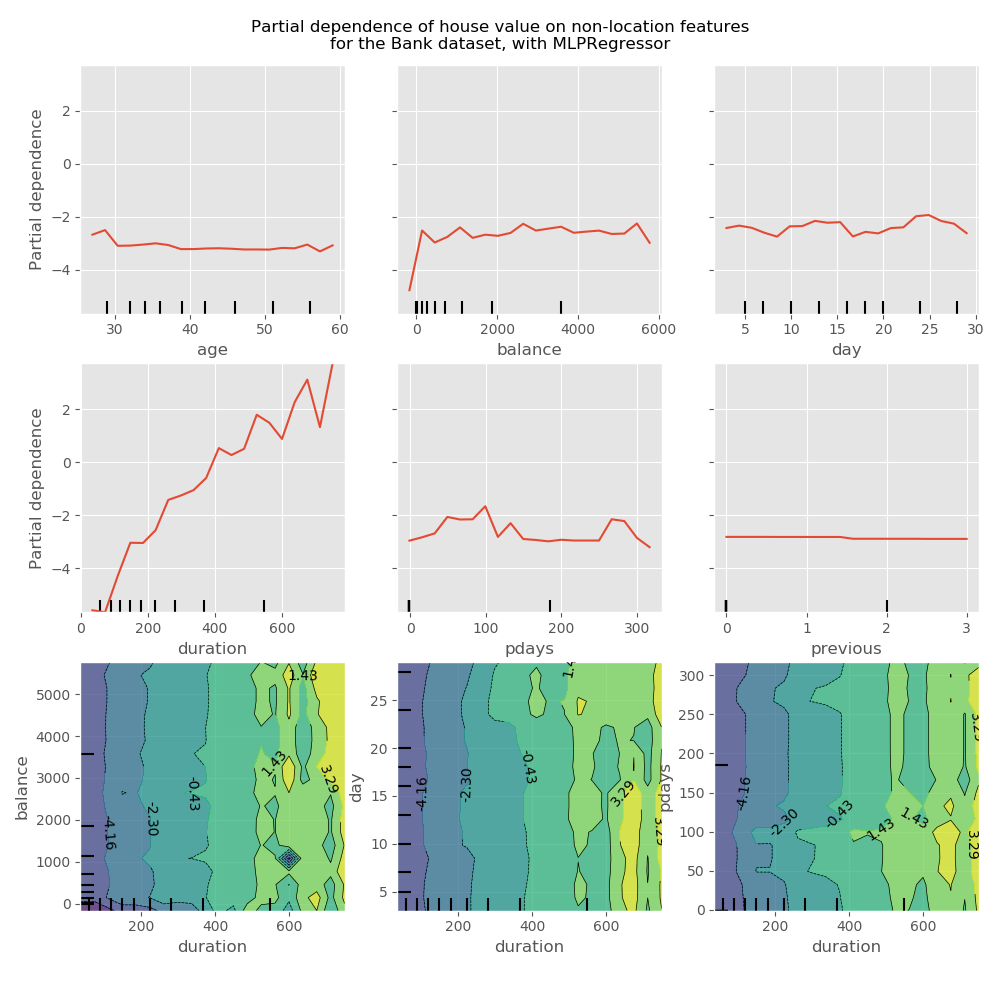

In [86]:
# features = [0,1,2,3,4, (0,1)]
#nomor fitur dan gabungan dari fitur
# plot_partial_dependence(gbc, temp, features)
# plt.gcf()

print('Computing partial dependence plots...')
# We don't compute the 2-way PDP (5, 1) here, because it is a lot slower
# with the brute method.
features = [0,1,2,3,4,5, (3,1), (3,2), (3,4)]
# features = list(temp.columns)
plot_partial_dependence(gbc, temp, features,
                        n_jobs=-1, grid_resolution=20,verbose=True, method="auto")
fig = plt.gcf()
fig.set_size_inches(10,10)
fig.suptitle('Partial dependence of house value on non-location features\n'
             'for the Bank dataset, with MLPRegressor', va="top")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## 3d plot

In [ ]:
fig = plt.figure()

features = ('AveOccup', 'HouseAge')
pdp, axes = partial_dependence(est, X_train, features=features,
                               grid_resolution=20)
XX, YY = np.meshgrid(axes[0], axes[1])
Z = pdp[0].T
ax = Axes3D(fig)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1,
                       cmap=plt.cm.BuPu, edgecolor='k')
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel('Partial dependence')
#  pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle('Partial dependence of house value on median\n'
             'age and average occupancy, with Gradient Boosting')
plt.subplots_adjust(top=0.9)

plt.show()

# other library ?

A few items are worth pointing out as you interpret this plot

   1. The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.
   2. A blue shaded area indicates level of confidence

From this particular graph, we see that scoring a goal substantially increases your chances of winning "Man of The Match." But extra goals beyond that appear to have little impact on predictions.

in general, the smooth shape of this curve seems more plausible than the step function

<IPython.core.display.Javascript object>


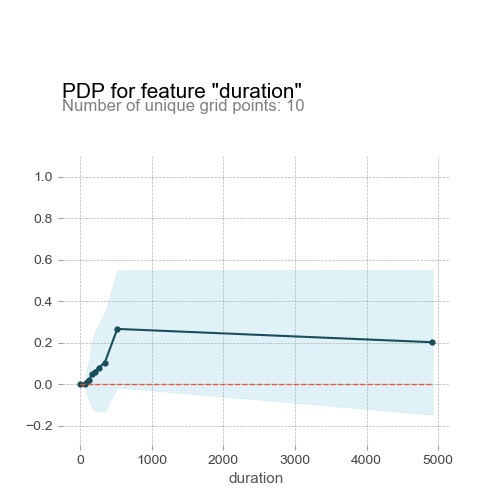

In [103]:
# Create the data that we will plot
features = list(temp.columns)
pdp_goals = pdp.pdp_isolate(model=gbc, dataset=temp, model_features=features, feature='duration')

# plot it
pdp.pdp_plot(pdp_goals, 'duration')
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

<IPython.core.display.Javascript object>


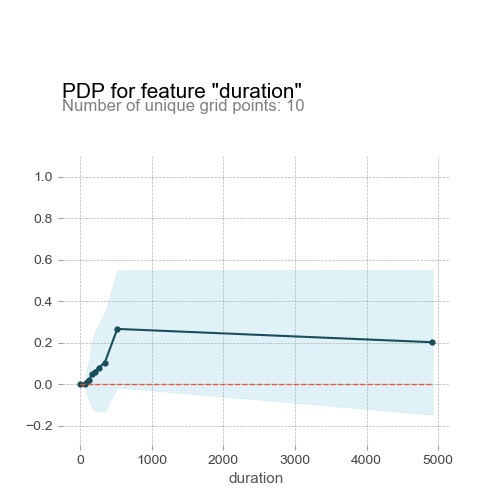

In [105]:
feature_to_plot = "duration"
pdp_dist = pdp.pdp_isolate(model=gbc, dataset=temp, model_features=features, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
fig = plt.gcf()
fig.set_size_inches(5,5)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

# save model

In [1]:
with open('test_imbalance_data', 'wb') as picklefile:
    pickle.dump(lr,picklefile)

NameError: name 'pickle' is not defined

# load 

In [33]:
with open('test_imbalance_data', 'rb') as training_model:
    model_1 = pickle.load(training_model)